<a href="https://colab.research.google.com/github/thanhnguyen2612/diveintocode-ml/blob/master/ML_sprint10_DeepNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## [Problem 1] Classifying fully connected layers

In [65]:
class FC:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
    @Params
        n_nodes1 : int
            Number of nodes in the previous layer
        n_nodes2 : int
            Number of nodes in the later layer
        initializer: instance of initialization method
        optimizer: instance of optimization method
    """
    def __init__(self, n_nodes1, n_nodes2, initializer,
                 activation, optimizer, bias=True):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.activation = activation
        self.optimizer = optimizer
        self.bias = bias
        self._init_weights()
    
    def _init_weights(self):
        self.W = self.initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        if self.optimizer.name == "AdaGrad":
            self.bias = False
            self.H = self.initializer.W(self.n_nodes1, self.n_nodes2)
            self.H.fill(1e-5)
        
    def forward(self, X):
        """
        Forward
        @Params
            X : The following forms of ndarray, shape (batch_size, n_nodes1)
        @Returns
            A : The following forms of ndarray, shape (batch_size, n_nodes2)
                output
        """
        self.input = X
        self.A = self.input @ self.W + self.B if self.bias else self.input @ self.W
        self.output = self.activation.forward(self.A)
        return self.output

    def backward(self, d):
        if self.activation.name == "softmax":
            # Y_one_hot will be passed into param 'd'
            self.dA = self.activation.backward(self.output, d)
        else:
            # dZ will be passed into param 'd'
            self.dA = d * self.activation.backward(self.A)

        dZ = self.dA @ self.W.T
        self.optimizer.update(self)
        return dZ

## [Problem 2] Classifying the initialization method

In [3]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    @Params
        sigma : float
            Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma=0.02, seed=None):
        self.sigma = sigma
        self.seed = seed
        np.random.seed(seed)

    def W(self, n_nodes1, n_nodes2):
        """
        Weight initialization
        @Params
            n_nodes1 : int
                Number of nodes in the previous layer
            n_nodes2 : int
                Number of nodes in the later layer
        @Returns
            W : initial weights, shape (n_nodes1, n_nodes2)
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        """
        Bias initialization
        @Params
            n_nodes2 : int
                Number of nodes in the later layer
        @Returns
            B : initial weights for bias, shape (1, n_nodes2)
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

## [Problem 3] Classifying optimization methods

In [4]:
class SGD:
    """
    Stochastic gradient descent
    @Params
        lr : Learning rate
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        self.name = "SGD"
    def update(self, layer):
        """
        Update weights and biases for a layer
        @Params
            layer : Instance of the layer before update
        """
        grad_W = layer.input.T @ layer.dA
        grad_B = np.sum(layer.dA, axis=0)
        layer.W -= self.lr * grad_W
        layer.B -= self.lr * grad_B
        return layer

## [Problem 4] Classifying activation functions

In [5]:
class Tanh:
    def __init__(self):
        self.name = "tanh"
    def forward(self, X):
        return (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))
    def backward(self, X):
        return 1 - self.forward(X) ** 2
class Sigmoid:
    def __init__(self):
        self.name = "sigmoid"
    def forward(self, X):
        return 1 / (1 + np.exp(X))
    def backward(self, X):
        return self.forward(X) * (1 - self.forward(X))
class Softmax:
    def __init__(self):
        self.name = "softmax"
    def forward(self, X):
        return np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1, 1)
    def backward(self, X, Y):
        return X - Y

## Test

In [6]:
class GetMiniBatch:
    """
    Iterator to get a mini-batch
    @Parameters
        X : The following forms of ndarray, shape (n_samples, n_features)
            Training data
        y : The following form of ndarray, shape (n_samples, 1)
            Correct answer value
        batch_size : int
            Batch size
        seed : int
            NumPy random number seed
    """
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

class ScratchDeepNeuralNetworkClassifier:
    def __init__(self, batch_size=1, epochs=10, layers=[],
                 random_state=None, verbose=True):
        self.batch_size = batch_size
        self.epochs = epochs
        self.layers = layers.copy()        # A list of FC layers
        self.random_state = random_state
        self.verbose = verbose
    
    def add(self, layer):
        """
        @Params:
            layer: object of class Layer
        """
        self.layers.append(layer)
        return self
    
    def _feedforward(self, X):
        Z = X.copy()
        for layer in self.layers:
            Z = layer.forward(Z)
        return Z
    
    def _backpropagation(self, y):
        dZ = y.copy()
        for layer in self.layers[::-1]:
            dZ = layer.backward(dZ)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn a neural network classifier.
        @Parameters
            X : The following forms of ndarray, shape (n_samples, n_features)
                Features of training data
            y : The following form of ndarray, shape (n_samples,)
                Correct answer value of training data
            X_val : The following forms of ndarray, shape (n_samples, n_features)
                Features of verification data
            y_val : The following form of ndarray, shape (n_samples,)
                Correct value of verification data
        """
        self.train_loss = []
        self.val_loss = []
        for i in range(self.epochs):
            mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=self.random_state)
            for mini_X, mini_y in mini_batch:
                self._feedforward(mini_X)
                self._backpropagation(mini_y)

            self.train_loss.append(cross_entropy_loss(y, self.predict_proba(X)))
            if X_val is not None and y_val is not None:
                self.val_loss.append(cross_entropy_loss(y_val, self.predict_proba(X_val)))

            if self.verbose:
                print("Epoch", i, "Loss:", self.train_loss[-1])

        return self
    
    def predict_proba(self, X):
        return self._feedforward(X)

    def predict(self, X):
        """
        Estimate using a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples,)
            Estimated result
        """
        y_proba = self._feedforward(X)
        return np.argmax(y_proba, axis=1)

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

def cross_entropy_loss(y_true, y_proba, tol=1e-7):
    error_per_sample = np.sum(y_true * np.log(y_proba + tol), axis=1)
    L = -np.mean(error_per_sample)
    return L

def evaluate(X, y, y_one_hot, model):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)
    print("ROC AUC:", roc_auc_score(y_one_hot, y_proba))
    print(classification_report(y, y_pred))
    sns.heatmap(confusion_matrix(y, y_pred), cmap=plt.cm.Blues, annot=True)
    plt.show()
    
def plot_learning_curve(train_loss, val_loss=None):
    plt.figure(figsize=(16, 8))
    plt.plot(train_loss, label="train_loss", linewidth=5)
    if val_loss is not None:
        plt.plot(val_loss, label="val_loss", linewidth=5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

In [8]:
from keras.datasets import mnist
(X_train, y_train), (X_val, y_val) = mnist.load_data()
X_train = X_train.reshape(-1, 28 * 28)
X_val = X_val.reshape(-1, 28 * 28)
X_train = X_train.astype(np.float)
X_val = X_val.astype(np.float)
X_train /= 255
X_val /= 255

In [9]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train.reshape(-1, 1))
y_val_one_hot = enc.transform(y_val.reshape(-1, 1))

y_train.shape, y_train_one_hot.shape, y_val.shape, y_val_one_hot.shape

((60000,), (60000, 10), (10000,), (10000, 10))

In [10]:
FC1 = FC(784, 400, initializer=SimpleInitializer(), activation=Tanh(), optimizer=SGD())
FC2 = FC(400, 200, initializer=SimpleInitializer(), activation=Tanh(), optimizer=SGD())
FC3 = FC(200, 10, initializer=SimpleInitializer(), activation=Softmax(), optimizer=SGD())
model = ScratchDeepNeuralNetworkClassifier(batch_size=20, epochs=10)
model.add(FC1)
model.add(FC2)
model.add(FC3)
model.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

Epoch 0 Loss: 0.14579193104557137
Epoch 1 Loss: 0.12024342777578804
Epoch 2 Loss: 0.07556032882620922
Epoch 3 Loss: 0.050495206347168704
Epoch 4 Loss: 0.03743911193958148
Epoch 5 Loss: 0.03478623073667664
Epoch 6 Loss: 0.019438597930817744
Epoch 7 Loss: 0.021428287773936777
Epoch 8 Loss: 0.011277613083927473
Epoch 9 Loss: 0.009676855197277257


ROC AUC: 0.9996727152733289
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.97      0.98      0.98       958
           7       0.96      0.98      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.98      0.94      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



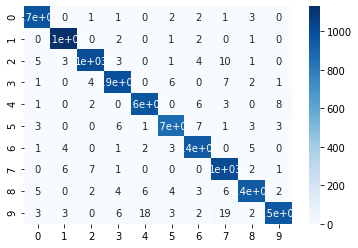

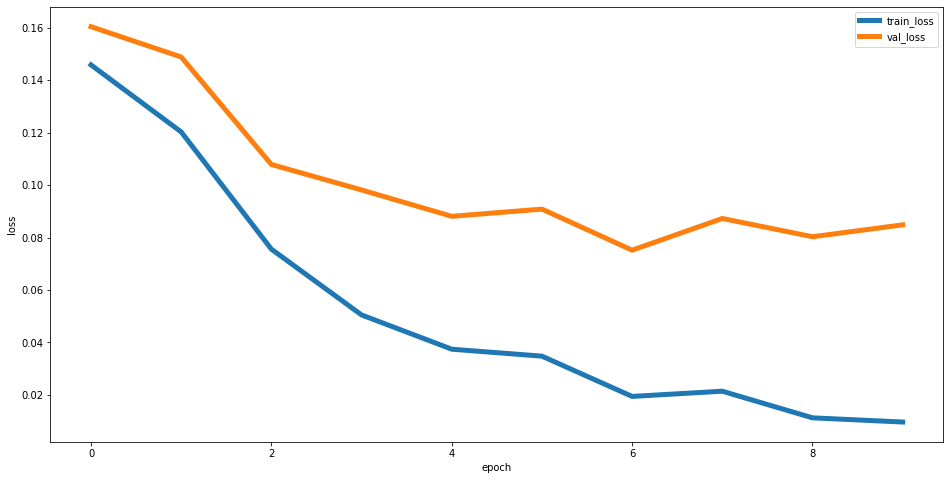

In [11]:
evaluate(X_val, y_val, y_val_one_hot, model)
plot_learning_curve(model.train_loss, model.val_loss)

## [Problem 5] ReLU class creation

In [12]:
class ReLU():
    def __init__(self):
        self.name = "ReLU"
    def forward(self, X):
        return np.maximum(X, 0)
    def backward(self, X):
        return np.where(X > 0, 1, 0)

## [Problem 6] Initial value of weight

In [13]:
class XavierInitializer():
    def __init__(self, seed=None):
        self.seed = seed
        np.random.seed(seed)

    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

class HeInitializer():
    def __init__(self, seed=None):
        self.seed = seed
        np.random.seed(seed)

    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

Xavier with Tanh activation

In [14]:
FC1 = FC(784, 400, initializer=XavierInitializer(), activation=Tanh(), optimizer=SGD())
FC2 = FC(400, 200, initializer=XavierInitializer(), activation=Tanh(), optimizer=SGD())
FC3 = FC(200, 10, initializer=SimpleInitializer(), activation=Softmax(), optimizer=SGD())
model = ScratchDeepNeuralNetworkClassifier(batch_size=20, epochs=10)
model.add(FC1)
model.add(FC2)
model.add(FC3)
model.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

Epoch 0 Loss: 0.13113404390642003
Epoch 1 Loss: 0.08098959795946732
Epoch 2 Loss: 0.05449988751714425
Epoch 3 Loss: 0.03874794577575291
Epoch 4 Loss: 0.035132528743274306
Epoch 5 Loss: 0.028153906917664798
Epoch 6 Loss: 0.02197787904359035
Epoch 7 Loss: 0.01075992555059963
Epoch 8 Loss: 0.0057362188310964395
Epoch 9 Loss: 0.004978269495453312


ROC AUC: 0.9996995178890502
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.97      0.97       982
           5       0.98      0.97      0.98       892
           6       0.97      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.96      0.98      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



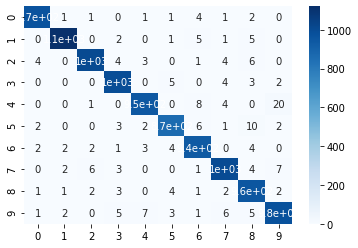

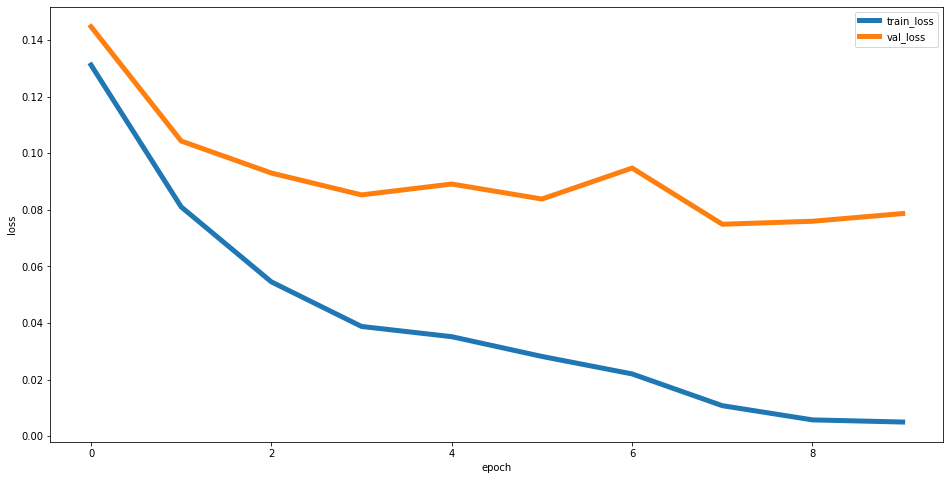

In [15]:
evaluate(X_val, y_val, y_val_one_hot, model)
plot_learning_curve(model.train_loss, model.val_loss)

He with ReLU activation

In [16]:
FC1 = FC(784, 400, initializer=HeInitializer(), activation=ReLU(), optimizer=SGD())
FC2 = FC(400, 200, initializer=HeInitializer(), activation=ReLU(), optimizer=SGD())
FC3 = FC(200, 10, initializer=SimpleInitializer(), activation=Softmax(), optimizer=SGD())
model = ScratchDeepNeuralNetworkClassifier(batch_size=20, epochs=10)
model.add(FC1)
model.add(FC2)
model.add(FC3)
model.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

Epoch 0 Loss: 0.0810555624759127
Epoch 1 Loss: 0.046197678606111334
Epoch 2 Loss: 0.049738442115555594
Epoch 3 Loss: 0.03688464014085633
Epoch 4 Loss: 0.020116788812957274
Epoch 5 Loss: 0.020591000578002273
Epoch 6 Loss: 0.01271501159555167
Epoch 7 Loss: 0.014863845795110447
Epoch 8 Loss: 0.012122436100831125
Epoch 9 Loss: 0.005392948671239077


ROC AUC: 0.9997384118172572
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



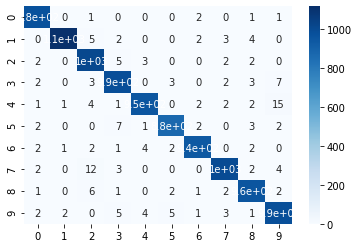

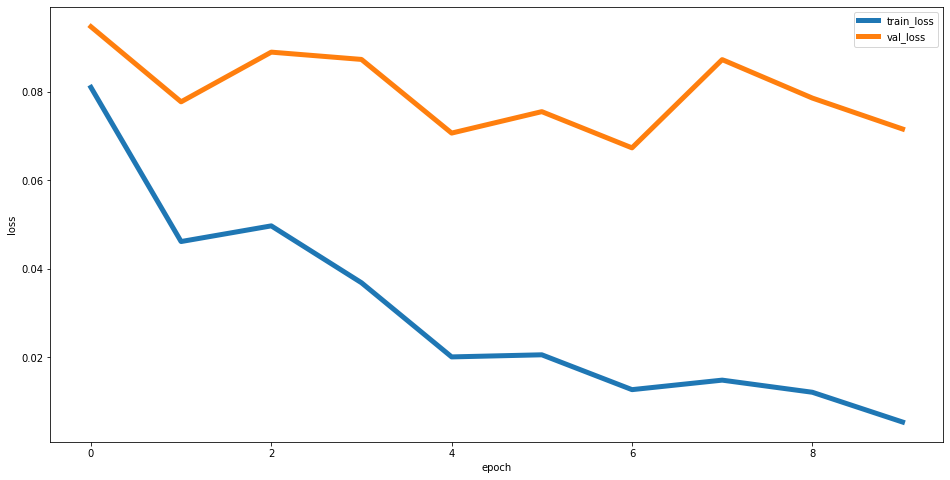

In [17]:
evaluate(X_val, y_val, y_val_one_hot, model)
plot_learning_curve(model.train_loss, model.val_loss)

## [Problem 7] Optimization method

In [63]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.name = "AdaGrad"
    def update(self, layer):
        """
        Update weights and biases for a layer
        @Params
            layer : Instance of the layer before update
        """
        grad_W = layer.input.T @ layer.dA
        layer.H += grad_W ** 2
        layer.W -= self.lr * (grad_W / np.sqrt(layer.H))
        return layer

## [Problem 8] Class completion & [Problem 9] Learning and estimation
Have tried some configuration, now I will use AdaGrad on them

In [68]:
FC1 = FC(784, 400, initializer=SimpleInitializer(), activation=Tanh(), optimizer=AdaGrad())
FC2 = FC(400, 200, initializer=SimpleInitializer(), activation=Tanh(), optimizer=AdaGrad())
FC3 = FC(200, 10, initializer=SimpleInitializer(), activation=Softmax(), optimizer=AdaGrad())
model = ScratchDeepNeuralNetworkClassifier(batch_size=20, epochs=5)
model.add(FC1)
model.add(FC2)
model.add(FC3)
model.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

Epoch 0 Loss: 0.16341738388501711
Epoch 1 Loss: 0.11707861175480204
Epoch 2 Loss: 0.09480585760143079
Epoch 3 Loss: 0.07948207578890397
Epoch 4 Loss: 0.06826763984843337


ROC AUC: 0.9994024081363888
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.98      0.97       892
           6       0.97      0.97      0.97       958
           7       0.96      0.98      0.97      1028
           8       0.97      0.96      0.97       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



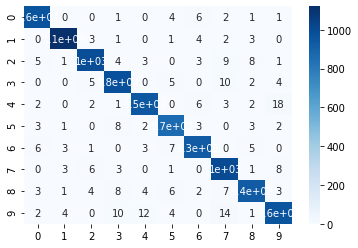

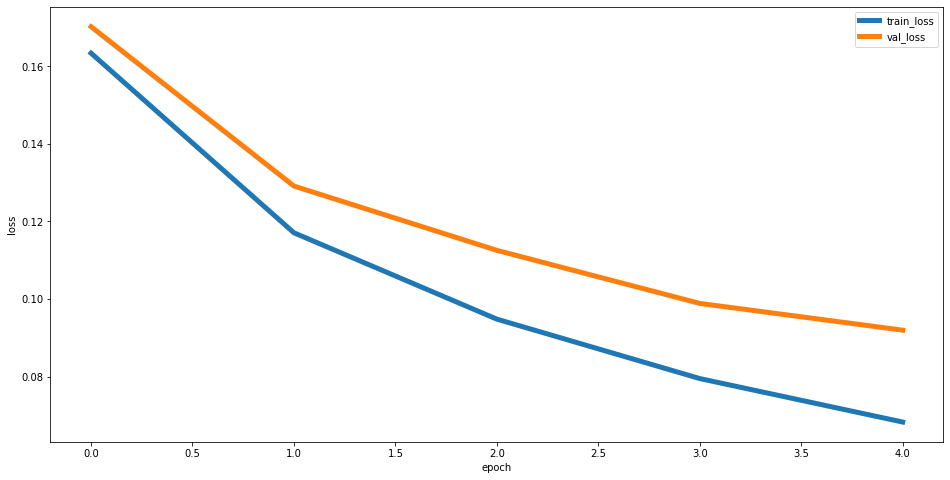

In [69]:
evaluate(X_val, y_val, y_val_one_hot, model)
plot_learning_curve(model.train_loss, model.val_loss)

In [66]:
FC1 = FC(784, 400, initializer=XavierInitializer(), activation=Tanh(), optimizer=AdaGrad())
FC2 = FC(400, 200, initializer=XavierInitializer(), activation=Tanh(), optimizer=AdaGrad())
FC3 = FC(200, 10, initializer=SimpleInitializer(), activation=Softmax(), optimizer=AdaGrad())
model = ScratchDeepNeuralNetworkClassifier(batch_size=20, epochs=5)
model.add(FC1)
model.add(FC2)
model.add(FC3)
model.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

Epoch 0 Loss: 0.14617863480972326
Epoch 1 Loss: 0.10476595384588794
Epoch 2 Loss: 0.0850143703896183
Epoch 3 Loss: 0.07207946956151999
Epoch 4 Loss: 0.061456190558757326


ROC AUC: 0.9994829857777987
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.98      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



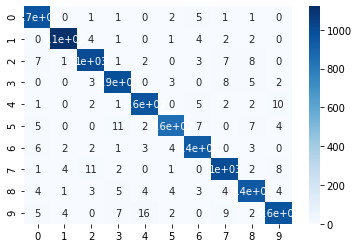

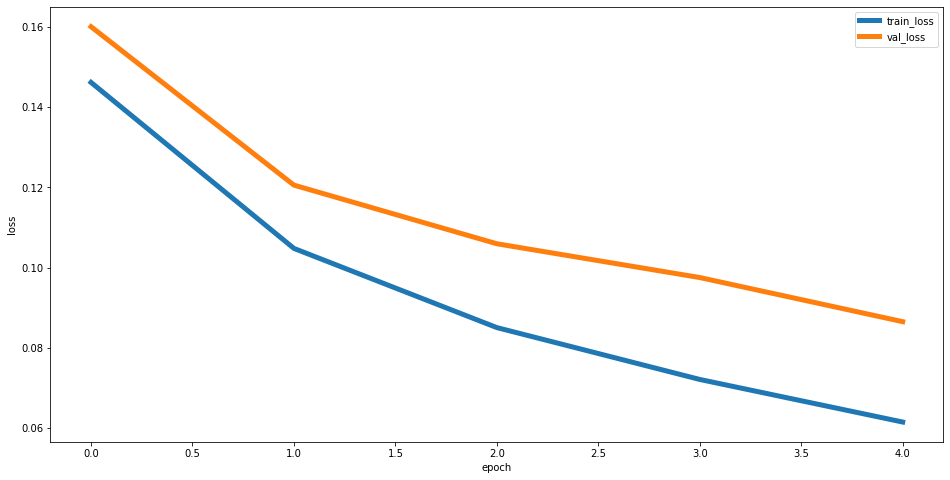

In [67]:
evaluate(X_val, y_val, y_val_one_hot, model)
plot_learning_curve(model.train_loss, model.val_loss)

In [70]:
FC1 = FC(784, 400, initializer=HeInitializer(), activation=ReLU(), optimizer=AdaGrad())
FC2 = FC(400, 200, initializer=HeInitializer(), activation=ReLU(), optimizer=AdaGrad())
FC3 = FC(200, 10, initializer=SimpleInitializer(), activation=Softmax(), optimizer=AdaGrad())
model = ScratchDeepNeuralNetworkClassifier(batch_size=20, epochs=5)
model.add(FC1)
model.add(FC2)
model.add(FC3)
model.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

Epoch 0 Loss: 0.09053325084877932
Epoch 1 Loss: 0.061104332118497785
Epoch 2 Loss: 0.04510533635148793
Epoch 3 Loss: 0.03512675829141081
Epoch 4 Loss: 0.028136055247713763


ROC AUC: 0.9997216789429201
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.97      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



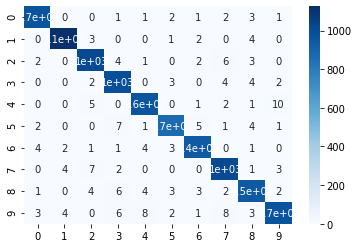

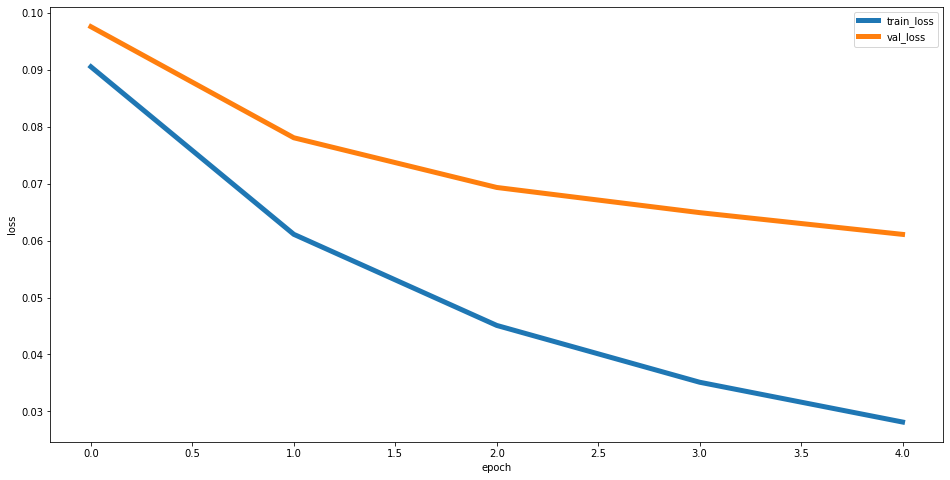

In [71]:
evaluate(X_val, y_val, y_val_one_hot, model)
plot_learning_curve(model.train_loss, model.val_loss)